In [1]:
import os
# change the default cache dir so that huggingface won't take the cse space.
os.environ['TRANSFORMERS_CACHE'] = '/export/scratch/zeren/KimNLP/HuggingfaceCache/'

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import confusion_matrix, f1_score
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from Model import LanguageModel, EarlyFuseClassifier, MLPClassifier


Bad key "text.kerning_factor" on line 4 in
/export/scratch/Zeren/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
nclasses = {'kim':3, 'acl':6, 'scicite':3}
data_name = 'scicite'
lm='scibert'
seed='42'

model_filename = os.path.join(
    '/export/scratch/zeren/KimNLP/Code/kim-citation-classification/Workspaces', 
    'baseline{}_{}_seed{}'.format(data_name, lm, seed),
    'best_model.pt')
filename = '/export/scratch/zeren/KimNLP/Code/kim-citation-classification/Scripts/predictions/{}_{}_cls_{}_predictions.csv'.format(data_name, lm, seed)
scores = pd.read_csv('/export/scratch/zeren/KimNLP/Code/kim-citation-classification/Scripts/{}_{}_cls_{}_scores.csv'.format(data_name, lm, seed))
data = pd.read_csv(filename)
data.head()

,input_text,label,pred_label
0,"[CLS] chapel, as well as x10 [ 2 ], < cited he...",background,background
1,"[CLS] in addition, the result of the present s...",result,result
2,[CLS] several instruments that more specifical...,background,background
3,[CLS] organotypic hippocampal slice cultures i...,method,method
4,[CLS] activated pbmc are the basis of the stan...,background,method


In [79]:
scores.head()

,input_text,label,not used,used,extended
0,[CLS] interest. such studies can shed the ligh...,not used,0.999464,0.000518,0.000018
1,[CLS] several dozen semi - empirical potential...,used,0.038501,0.151208,0.810291
2,[CLS] simulation methods are usually employed....,not used,0.990689,0.008088,0.001223
3,[CLS] such a density as the sum of contributio...,not used,0.997449,0.002365,0.000187
4,"[CLS] germanium, gallium arsenite, etc., are c...",not used,0.827493,0.130831,0.041676


In [80]:
threshold = 0.95

labels = list(scores.columns)[2:]
labeldict = {l:i for i, l in enumerate(labels)}

for l in labels:
    scores['pred_{}'.format(l)] = scores[l] > threshold
    scores['bool_{}'.format(l)] = scores['label'] == l

In [81]:
lb = 'used'
error = scores[scores['pred_{}'.format(lb)]]
error = error[~error['bool_{}'.format(lb)]]
# error = error[['input_text', 'label']]
print(error)

for t in error['input_text'].values:
    print(t)

                                            input_text     label  not used  \
73   [CLS] deformation tests at zero - temperature ...  not used  0.027092   
120  [CLS] applied to calculate the interactions am...  not used  0.013752   

         used  extended  pred_not used  bool_not used  pred_used  bool_used  \
73   0.972191  0.000717          False           True       True      False   
120  0.984426  0.001822          False           True       True      False   

     pred_extended  bool_extended  
73           False          False  
120          False          False  
[CLS] deformation tests at zero - temperature are performed to decouple thermal vibration from mechanical deformation. as mentioned in the previous section, npt ensemble simulations with < cited here > 333. 9 aryanpour et al. [ 26 ] 359. 4 singh et al. [ 27 ] 409. 6 fig. 3. potential energies of epoxy - cured system at different temperatures during ( a ) equilibration, and ( b ) uniaxial deformation. absolute 0 k se

In [82]:
scores['labelid'] = scores['label'].apply(lambda x: labeldict[x])

thlist = np.arange(0., 1., 0.01)

recall_dict = {l:[] for l in labels}
prec_dict = {l:[] for l in labels}
for l in labels:
    sub_df = scores[['label', l]]

    sub_df = sub_df.sort_values(by=l)
    for th in thlist:
        sub_df['pred'] = sub_df[l] > th
        sub_df['bool_label'] = sub_df['label'] == l
        recall = (sub_df['pred'].values * sub_df['bool_label'].values).sum() / (sub_df['bool_label'].sum() + 1e-24)
        prec = (sub_df['pred'].values * sub_df['bool_label'].values).sum() / (sub_df['pred'].sum() + 1e-24)
        recall_dict[l].append(recall)
        prec_dict[l].append(prec)

In [83]:
# def compute_recall_precision(df, threshold):
#     labels = list(df.columns)[2:]
#     labeldict = {l:i for i, l in enumerate(labels)}

#     conf = np.zeros((len(labels), len(labels)))
#     for i, sc in enumerate(df[labels].values):
#         gtl = labeldict[df['label'].values[i]]
#         for j, s in enumerate(sc):
#             if s > threshold:
#                 conf[gtl, j] += 1
    
#     return conf

In [84]:
# def compute_recall_precision(df, threshold):
#     labels = list(df.columns)[2:]
#     labeldict = {l:i for i, l in enumerate(labels)}

#     count = {l:0. for l in labels}
#     rec = {l:0. for l in labels}
#     prec = {l:0. for l in labels}
#     for i, sc in enumerate(df[labels].values):
#         gtl = df['label'].values[i]
#         pred = []
#         for j, s in enumerate(sc):
#             if s > threshold:
#                 pred.append(labels[j])

#         count[gtl] += 1

#         if gtl in pred:
#             rec[gtl] += 1.
#             prec[gtl] += 1. / len(pred)
    
#     final_rec = {}
#     final_prec = {}
#     for key in rec.keys():
#         final_rec[key] = rec[key] / count[key]
#         final_prec[key] = prec[key] / count[key]
#     return final_rec, final_prec

In [85]:
# confmat = compute_recall_precision(scores, 0.3)
# thlist = np.arange(0.1, 1., 0.1)

# labels = list(scores.columns)[2:]

# recall = {l:[] for l in labels}
# prec = {l:[] for l in labels}
# for th in thlist:
#     confmat = compute_recall_precision(scores, th)

#     for i in range(len(labels)):
#         recall[labels[i]].append(confmat[i, i] / confmat[i, :].sum())
#         prec[labels[i]].append(confmat[i, i] / confmat[:, i].sum())

In [86]:
# confmat = compute_recall_precision(scores, 0.3)
# thlist = np.arange(0., 1.1, 0.1)

# labels = list(scores.columns)[2:]

# recall = {l:[] for l in labels}
# prec = {l:[] for l in labels}
# for th in thlist:
#     frec, fprec = compute_recall_precision(scores, th)

#     for i in labels:
#         recall[i].append(frec[i])
#         prec[i].append(fprec[i])

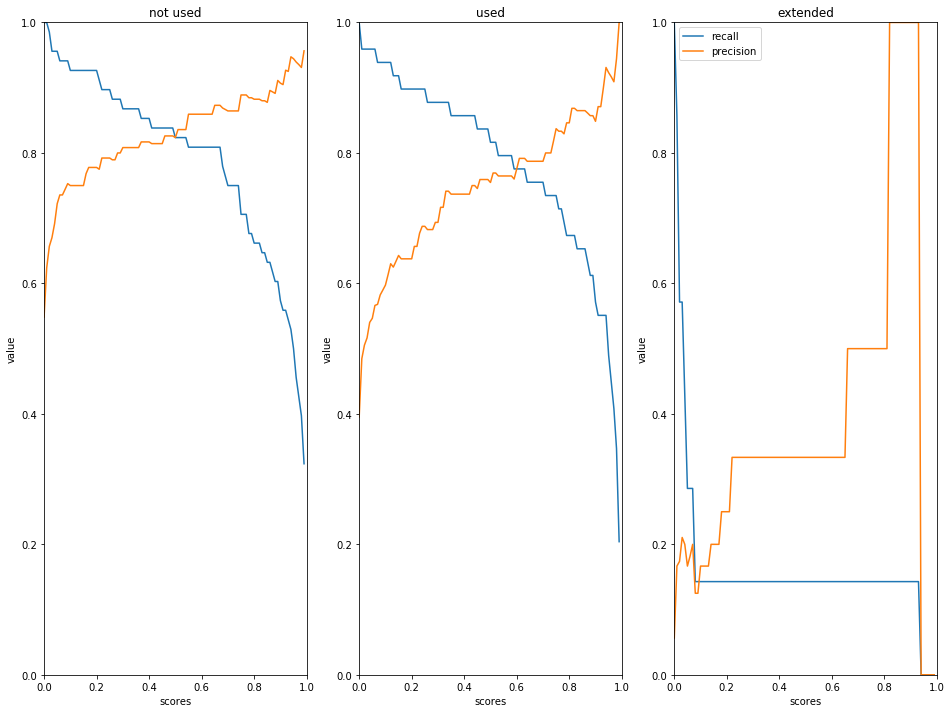

In [87]:
plt.figure(figsize=(16, 12))
num_rows = len(labels) // 3
num_columns = 3
for i, l in enumerate(labels):
    plt.subplot(num_rows, num_columns, i+1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(thlist, recall_dict[l], label='recall')
    plt.plot(thlist, prec_dict[l], label='precision')
    plt.title(l)
    plt.xlabel('scores')
    plt.ylabel('value')
plt.legend()
plt.savefig('{}_{}.png'.format(data_name, lm))
plt.show()

In [3]:
correct_data = data[data['label'] == data['pred_label']]
wrong_data = data[data['label'] != data['pred_label']]
labels = data['label'].unique()

In [4]:
print('Accuracy: {:.4f}, MacroF1: {:.4f}'.format(correct_data.shape[0] / data.shape[0], f1_score(data['label'], data['pred_label'], average='macro')))
print(labels)
confusion_matrix(data['label'], data['pred_label'], labels=labels)

Accuracy: 0.8587, MacroF1: 0.8477
['background' 'result' 'method']


array([[872,  69,  56],
       [ 16, 239,   4],
       [102,  16, 487]])

In [5]:
wrong_data['error_type'] = wrong_data['label'] + '->' + wrong_data['pred_label']
error_count = wrong_data[['error_type', 'label']].groupby('error_type').count().reset_index()
error_count

/export/scratch/Zeren/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,error_type,label
0,background->method,56
1,background->result,69
2,method->background,102
3,method->result,16
4,result->background,16
5,result->method,4


In [6]:
def valid_token(token):
    if len(token) < 4:
        return False
    
    if token[0] == '#' and token[1] == '#':
        return False
    
    return True

In [43]:
for line in wrong_data[wrong_data['error_type'] == 'background->result'].values:
    print(line[0])

[CLS] another signi®cant result described in this report is the similarity of mnude - l with the a. nidulans, mouse and rat nude proteins ( e®mov and morris, 2000 < cited here > 00 ). [SEP]
[CLS] similar biphasic profiles have been observed previously with reporter replicon systems derived from mosquito - borne flaviviruses ( alvarez et al., 2005 ; filomatori et al., 2006 ; holden et al., 2006 ; < cited here > ). [SEP]
[CLS] < cited here > support this idea : only patients with dgf requiring more than one - time dialysis had an increased risk for death, lower renal function and higher incidence of acute rejections during the first perioperative year. [SEP]
[CLS] there have been several studies reporting the association between low or high dose of statin and acute pancreatitis. < cited here > however, a larger scale meta - analysis reported a contradictory result. [SEP]
[CLS] previous studies reported that the development of vzv infection was delayed to 1 year after hct with 1 year of p

In [22]:
for line in correct_data[correct_data['label'] == 'CompareOrContrast'].values:
    print(line[0])

[CLS] < cited here > reported a correlation of r =. 9026. 10 the results are not directly comparable, because he only used noun - noun pairs, words instead of concepts, a much smaller dataset, and measured semantic similarity instead of semantic relatedness. [SEP]
[CLS] both tasks are performed with a statistical framework : the mention detection system is similar to the one presented in ( florian et al., 2004 ) and the coreference resolution system is similar to the one described in ( < cited here > ). [SEP]
[CLS] although there are other discussions of the paragraph as a central element of discourse ( e. g. < cited here >, halliday and hasan 1976, longacre 1979, haberlandt et al. 1980 ), all of them share a certain limitation in their formal techniques for analyzing paragraph structure. [SEP]
[CLS] a number of speech understanding systems have been developed during the past fifteen years ( barnett et al. 1980, dixon and martin 1979, erman et al. 1980, < cited here >, lea 1980, lowerr

In [13]:
data.head()

,input_text,label,pred_label
0,[CLS] interest. such studies can shed the ligh...,not used,not used
1,[CLS] several dozen semi - empirical potential...,used,extended
2,[CLS] simulation methods are usually employed....,not used,not used
3,[CLS] such a density as the sum of contributio...,not used,not used
4,"[CLS] germanium, gallium arsenite, etc., are c...",not used,not used


In [91]:
data['correct'] = (data['label'] == data['pred_label'])
data['label_transition'] = data['label'] + '->' + data['pred_label']

In [24]:
lm_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
# lm_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased').cuda()

lm_model = LanguageModel(
    modelname='allenai/scibert_scivocab_uncased',
    device='cuda',
    rawtext_readout='cls',
    context_readout='cls',
    intra_context_pooling='mean'
).cuda()

mlp_model = MLPClassifier(
    input_dims=lm_model.hidden_size,
    hidden_list=[1024,128,8],
    n_classes=nclasses[data_name],
    activation=torch.nn.ReLU,
    dropout=0.,
    device='cuda'
).cuda()
model = EarlyFuseClassifier(
    mlp_model=mlp_model,
    lm_model=lm_model
)
model.load_state_dict(torch.load(model_filename))
# lm_model = torch.load(model_filename)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:
embeds = []
lm_model.eval()
with torch.no_grad():
    for text in tqdm(data['input_text'].values):
        tokens = lm_tokenizer(text, return_tensors='pt', max_length=512)
        tokens = {key: values.cuda() for key, values in tokens.items()}
        embeds.append(lm_model(**tokens).last_hidden_state[0, 0].detach().cpu().numpy())
embeds = np.stack(embeds, axis=0)

  0%|          | 0/124 [00:00<?, ?it/s]

In [93]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(embeds)

# tsne = PCA(n_components=2)
# tsne_results = tsne.fit_transform(embeds)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 124 samples in 0.000s...
[t-SNE] Computed neighbors for 124 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 124 / 124
[t-SNE] Mean sigma: 5.659684
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.432285
[t-SNE] KL divergence after 500 iterations: 0.361241


/export/scratch/Zeren/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/export/scratch/Zeren/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


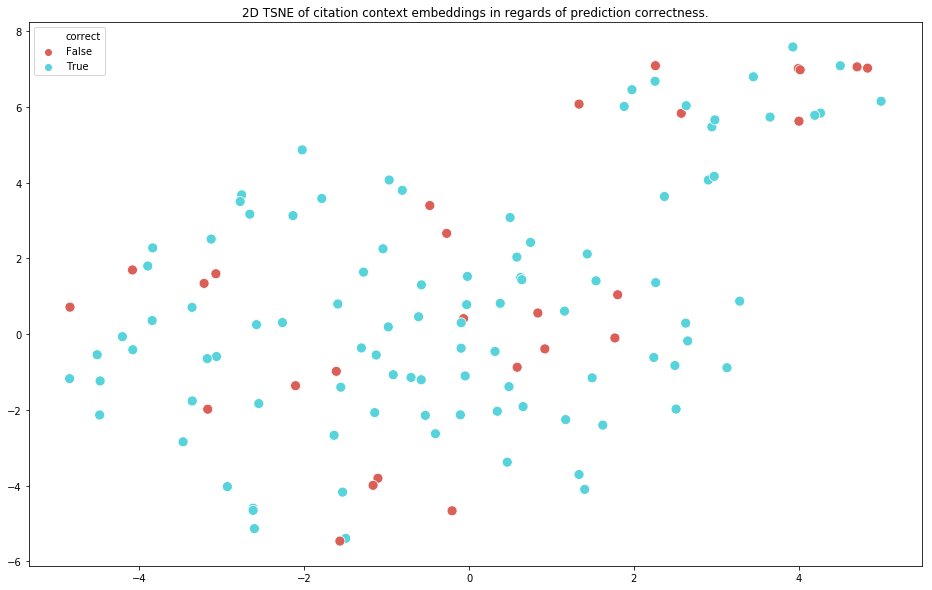

In [101]:
plt.figure(figsize=(16,10))
plt.title('2D TSNE of citation context embeddings in regards of prediction correctness.')
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=data['correct'],
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=1.,
    s=100
)

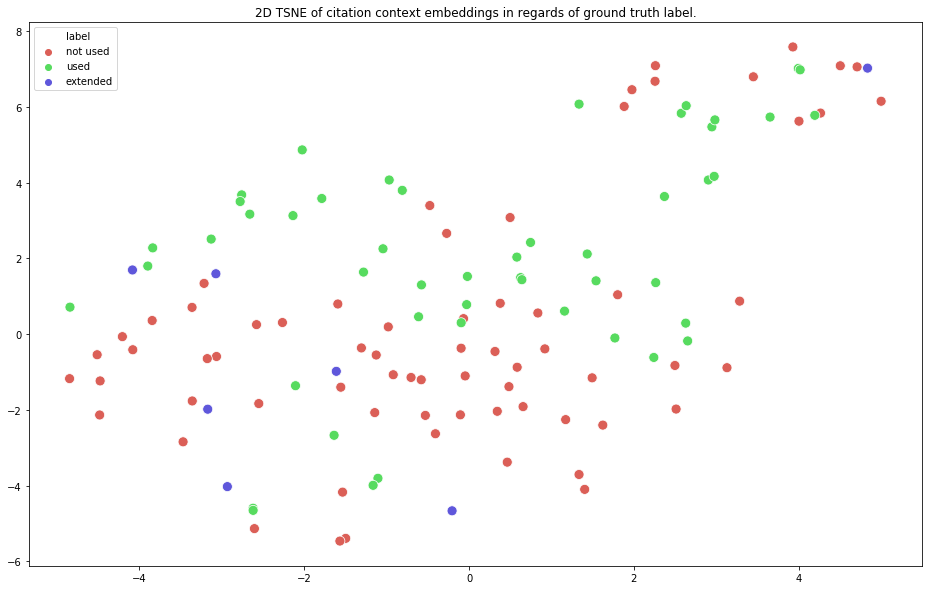

In [102]:
plt.figure(figsize=(16,10))
plt.title('2D TSNE of citation context embeddings in regards of ground truth label.')
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=data['label'],
    palette=sns.color_palette("hls", len(data['label'].unique())),
    legend="full",
    alpha=1.,
    s=100
)

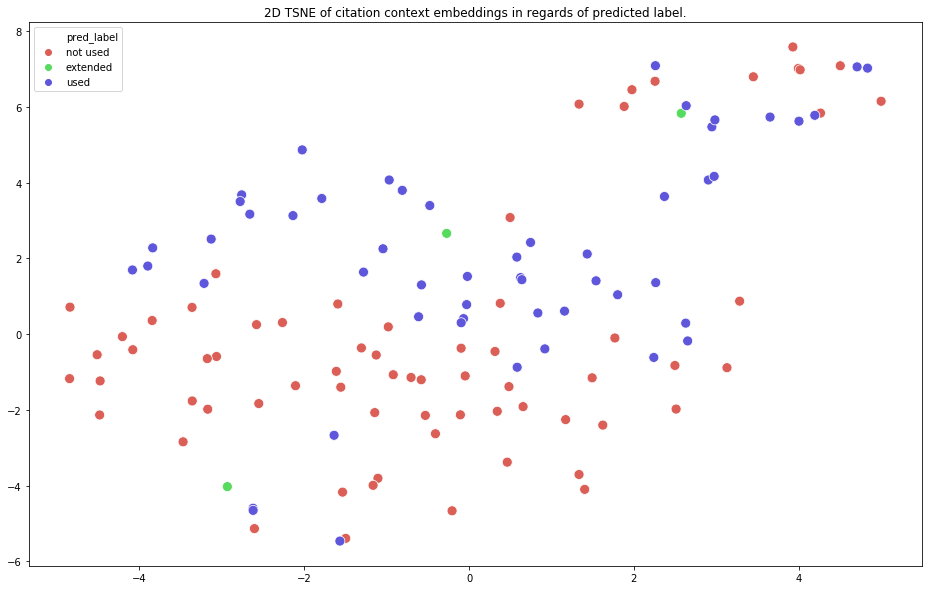

In [103]:
plt.figure(figsize=(16,10))
plt.title('2D TSNE of citation context embeddings in regards of predicted label.')
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=data['pred_label'],
    palette=sns.color_palette("hls", len(data['pred_label'].unique())),
    legend="full",
    alpha=1.,
    s=100
)

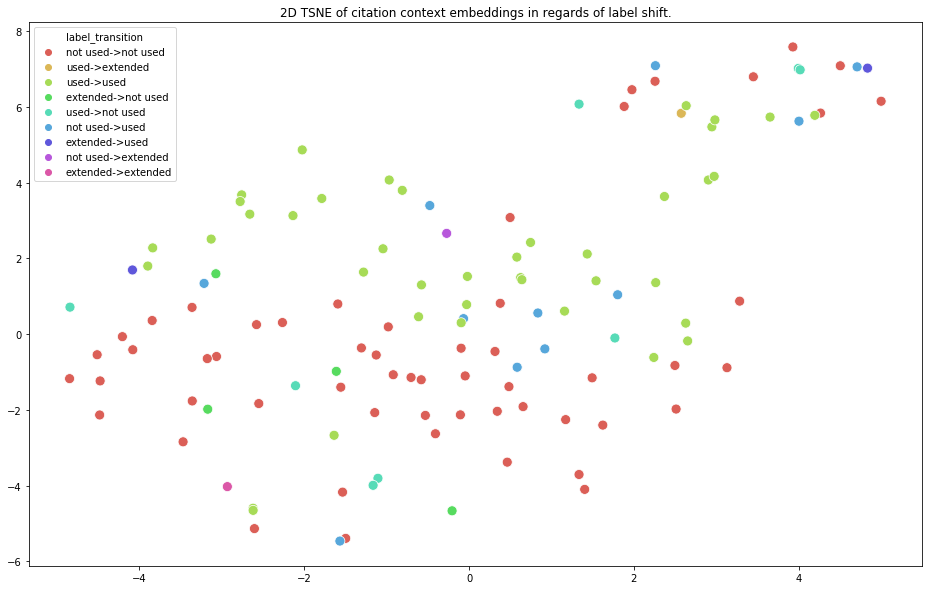

In [104]:
plt.figure(figsize=(16,10))
plt.title('2D TSNE of citation context embeddings in regards of label shift.')
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=data['label_transition'],
    palette=sns.color_palette("hls", len(data['label_transition'].unique())),
    legend="full",
    alpha=1.,
    s=100
)

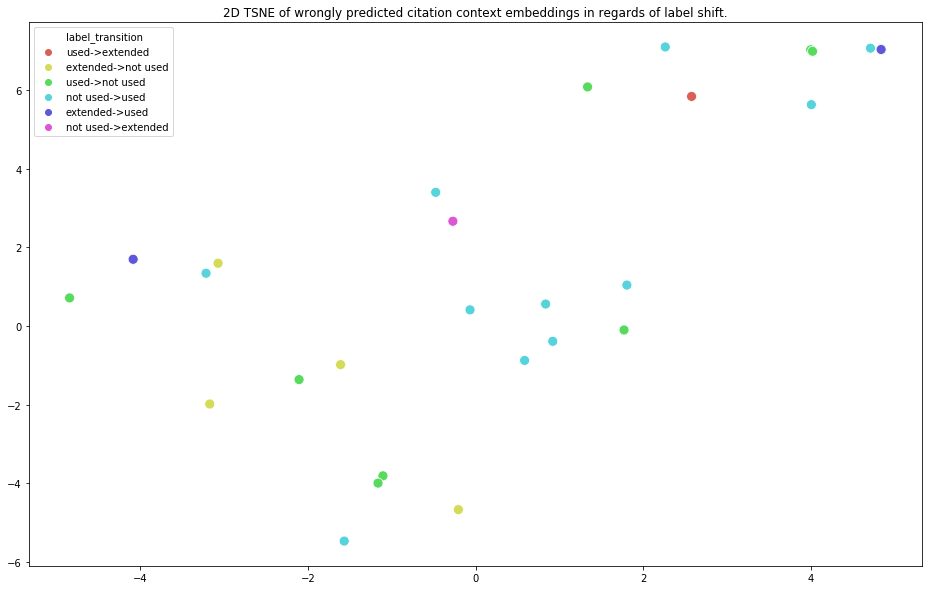

In [105]:
plt.figure(figsize=(16,10))
plt.title('2D TSNE of wrongly predicted citation context embeddings in regards of label shift.')
sns.scatterplot(
    x=tsne_results[~data['correct'].values, 0], y=tsne_results[~data['correct'].values, 1],
    hue=data['label_transition'][~data['correct'].values],
    palette=sns.color_palette("hls", len(data['label_transition'][~data['correct'].values].unique())),
    legend="full",
    alpha=1.,
    s=100
)